The objective of this notebook is to run BOW and Naive Bayes as our baseline model to have a reference in our experimentation


## MLFlow configuration

In [177]:
import mlflow
from mlflow.exceptions import RestException

In [ ]:
# on the console
# mlflow server --backend-store-uri=mlruns sqlite:///backend.db --default-artifact-root ./artifacts_local


mlflow.set_tracking_uri("http://127.0.0.1:5000")
mlflow.search_experiments()

[<Experiment: artifact_location='/home/maldu/dscience/projects/spam_detector/notebooks/experimentation/artifacts_local/1', creation_time=1733152016926, experiment_id='1', last_update_time=1733214392350, lifecycle_stage='active', name='spam-classifier', tags={'mlflow.note.content': 'This experiment contains mlruns for different '
                         'approaches in the ml lifecycle of an e-mail spam '
                         'detector classifier.',
  'project_name': 'spam-classifier',
  'project_quarter': 'Q4-2024',
  'project_stage': 'testing',
  'team': 'ml-team'}>,
 <Experiment: artifact_location='/home/maldu/dscience/projects/spam_detector/notebooks/experimentation/artifacts_local/0', creation_time=1733152009293, experiment_id='0', last_update_time=1733152009293, lifecycle_stage='active', name='Default', tags={}>]

In [179]:
from mlflow.tracking import MlflowClient

client = MlflowClient()

client.delete_run("81b0d40ddc814076a95bc6fd9d4fff34")

In [180]:
experiment_name = "spam-classifier"

experiment_description = (
    "This experiment contains mlruns for different approaches in the ml lifecycle of an e-mail spam detector classifier."
)

experiment_tags = {
    "project_name": "spam-classifier",
    "project_stage": "testing",
    "team": "ml-team",
    "project_quarter": "Q4-2024",
    "mlflow.note.content": experiment_description,
}



try:
    experiment_id = mlflow.create_experiment(name=experiment_name, tags=experiment_tags)
    print(f"Experiment created with ID: {experiment_id}")
except RestException as e:
    if "RESOURCE_ALREADY_EXISTS" in str(e):
        print(f"Experiment '{experiment_name}' already exists.")
        experiment_id = mlflow.get_experiment_by_name(experiment_name).experiment_id
    else:
        raise e

print(f"Working with experiment ID: {experiment_id}")

Experiment 'spam-classifier' already exists.
Working with experiment ID: 1


## Datasets

In [181]:
import pandas as pd
from mlflow.models import infer_signature


train = pd.read_csv("../../data/gold/train.csv")
test = pd.read_csv("../../data/gold/test.csv")

X_train = train['features']
y_train = train['target']
X_test = test['features']
y_test = test['target']
signature = infer_signature(X_train, y_train)

/home/maldu/.cache/pypoetry/virtualenvs/spam-detector-P2ybB3t6-py3.10/lib/python3.10/site-packages/mlflow/types/utils.py:407: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(


## Training model 

In [182]:
import mlflow.sklearn

import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score,
    roc_auc_score,
    f1_score,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    roc_curve
)

import os

artifact_root = "./artifacts_local/mlflow_artifacts"
os.makedirs(artifact_root, exist_ok=True)

pipeline = Pipeline([
        ('vectorizer', CountVectorizer(ngram_range=(1, 1), max_features=2000)),
        ('classifier', MultinomialNB())
    ])
    
pipeline.fit(X_train, y_train)

y_train_pred = pipeline.predict(X_train)
y_train_prob = pipeline.predict_proba(X_train)[:, 1]

train_accuracy = accuracy_score(y_train, y_train_pred)
train_roc_auc = roc_auc_score(y_train, y_train_prob)
train_f1 = f1_score(y_train, y_train_pred)


y_test_pred = pipeline.predict(X_test)
y_test_prob = pipeline.predict_proba(X_test)[:, 1]
test_f1 = f1_score(y_test, y_test_pred)

test_accuracy = accuracy_score(y_test, y_test_pred)
test_roc_auc = roc_auc_score(y_test, y_test_prob)


fpr_train, tpr_train, _ = roc_curve(y_train, y_train_prob)
fpr_test, tpr_test, _ = roc_curve(y_test, y_test_prob)




## Metrics

In [183]:

print("\nClassification Report (Training):")
print(classification_report(y_train, y_train_pred))



Classification Report (Training):
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      3606
           1       0.95      0.95      0.95       517

    accuracy                           0.99      4123
   macro avg       0.97      0.97      0.97      4123
weighted avg       0.99      0.99      0.99      4123



In [184]:
print("\nClassification Report (Test):")
print(classification_report(y_test, y_test_pred))


Classification Report (Test):
              precision    recall  f1-score   support

           0       0.99      0.97      0.98       453
           1       0.82      0.95      0.88        63

    accuracy                           0.97       516
   macro avg       0.91      0.96      0.93       516
weighted avg       0.97      0.97      0.97       516



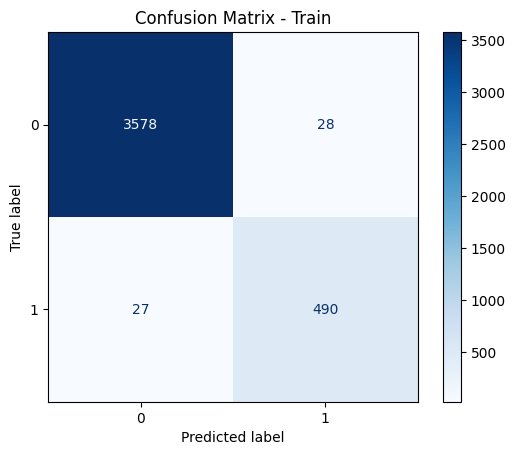

In [191]:
conf_matrix_train = confusion_matrix(y_train, y_train_pred)
disp_train = ConfusionMatrixDisplay(conf_matrix_train, display_labels=pipeline.classes_)
disp_train.plot(cmap='Blues')
plt.title("Confusion Matrix - Train")
train_conf_matrix_path = os.path.join(artifact_root, "conf_matrix_train.png")
plt.show()
plt.savefig(train_conf_matrix_path)
plt.close()

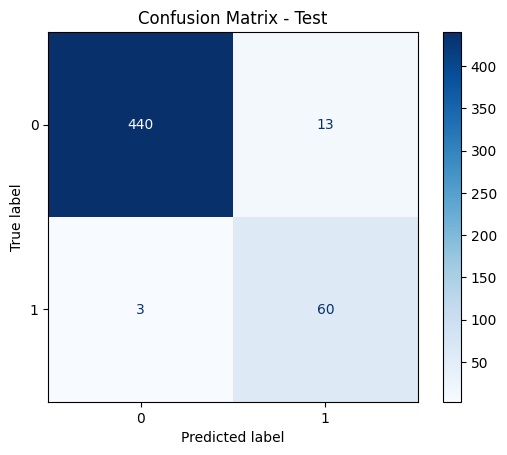

In [190]:
conf_matrix_test = confusion_matrix(y_test, y_test_pred)
disp_test = ConfusionMatrixDisplay(conf_matrix_test, display_labels=pipeline.classes_)
disp_test.plot(cmap='Blues')
plt.title("Confusion Matrix - Test")
test_conf_matrix_path = os.path.join(artifact_root, "conf_matrix_test.png")
plt.show()
plt.savefig(test_conf_matrix_path)
plt.close()

In [187]:
print("Training Accuracy:", train_accuracy)
print("Test Accuracy:", test_accuracy)
print(f"\nTraining AUC: {train_roc_auc}")
print(f"Test AUC: {test_roc_auc}")



Training Accuracy: 0.9866601988843076
Test Accuracy: 0.9689922480620154

Training AUC: 0.9915952458346341
Test AUC: 0.9844773818283752


In [188]:
plt.plot(fpr_train, tpr_train, label=f'Training AUC = {train_roc_auc:.3f}')
plt.plot(fpr_test, tpr_test, label=f'Test AUC = {test_roc_auc:.3f}')
plt.plot([0, 1], [0, 1], 'k--')  
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Train and Test ROC Curves')
plt.legend(loc='lower right')
roc_curve_path = os.path.join(artifact_root, "roc_curve.png")
plt.savefig(roc_curve_path)
plt.close()

## MlFlow tracking

In [189]:

mlflow.set_experiment(experiment_name)
    
with mlflow.start_run(run_name="baseline-model") as run:
    
    mlflow.set_tag("model", "Reference model MultinomialNB + BOW")

    #Datasets
    mlflow.log_param("data_folder", "../../data/gold/")
    mlflow.log_param("train_file", "train.csv")
    mlflow.log_param("test_file", "test.csv")
    
    #BOW and model
    mlflow.log_param("vectorizer_type", "CountVectorizer")
    mlflow.log_param("model_type", "MultinomialNB")
    
    # Metrics
    mlflow.log_metric("train_accuracy", train_accuracy)
    mlflow.log_metric("test_accuracy", test_accuracy)
    mlflow.log_metric("train_roc_auc", train_roc_auc)
    mlflow.log_metric("test_roc_auc", test_roc_auc)
    mlflow.log_metric("train_f1", train_f1)
    mlflow.log_metric("test_f1", test_f1)
    
    #Artifacts
    mlflow.log_artifact(train_conf_matrix_path, artifact_path="confusion_matrices")
    mlflow.log_artifact(test_conf_matrix_path, artifact_path="confusion_matrices")
    mlflow.log_artifact(roc_curve_path, artifact_path="roc_curves")

    
    # Pipeline
    mlflow.sklearn.log_model(pipeline, "pipeline",signature=signature)
    

    print(f"Pipeline logged to MLflow under run ID {run.info.run_id}")

Pipeline logged to MLflow under run ID cb986f7efd3d42eb8a5d327af93ba59f
🏃 View run baseline-model at: http://127.0.0.1:5000/#/experiments/1/runs/cb986f7efd3d42eb8a5d327af93ba59f
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1


Conclusions:

- Clear overfitting 